# Alma Zohar binary classification model

Designed to detect if Alma or Zohar using Transfer learning of the ResNet50 model







---







Import training set from My Drive

In [1]:
import os 
from google.colab import drive
drive.mount('/content/drive/')


# Directory with our training Zohar pictures
train_Zohar_dir = os.path.join('/content/drive/My Drive/ML/AlmaZohar/Training/Zohar')

# Directory with our training Alma pictures
train_Alma_dir = os.path.join('/content/drive/My Drive/ML/AlmaZohar/Training/Alma')

# Directory with our validation Zohar pictures
val_Zohar_dir = os.path.join('/content/drive/My Drive/ML/AlmaZohar/Validation/Zohar')

# Directory with our validation Alma pictures
val_Alma_dir = os.path.join('/content/drive/My Drive/ML/AlmaZohar/Validation/Alma')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


Check that there are no duplicate images in training and vaslidation set

In [2]:
print('total training Alma images:', len(os.listdir(train_Alma_dir)))
print('total training Zohar images:', len(os.listdir(train_Zohar_dir)))

print('total validation Alma images:', len(os.listdir(val_Alma_dir)))
print('total validation Zohar images:', len(os.listdir(val_Zohar_dir)))


!diff -srq '/content/drive/My Drive/ML/AlmaZohar/Training/Alma' '/content/drive/My Drive/ML/AlmaZohar/Validation/Alma' | grep identical
!diff -srq '/content/drive/My Drive/ML/AlmaZohar/Training/Zohar' '/content/drive/My Drive/ML/AlmaZohar/Validation/Zohar' | grep identical

total training Alma images: 44
total training Zohar images: 50
total validation Alma images: 10
total validation Zohar images: 10


# Transfer learning with ResNet50

In [26]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

HEIGHT = 300
WIDTH = 300

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))




def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(1, activation='sigmoid')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = ["Alma", "Zohar"]
FC_LAYERS = [512]
dropout = 0.1

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))



# Check the trainable status of the individual layers
# for layer in finetune_model.layers:
#     print(layer, layer.trainable)

finetune_model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

# Generate our small training set

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255,
                                  preprocessing_function=preprocess_input,
                                  rotation_range=90,
#                                   horizontal_flip=True,
#                                   vertical_flip=True,
                                  shear_range=0.2,
                                  zoom_range=0.2) # zoom in or out in images)

validation_datagen = ImageDataGenerator(rescale=1/255,
                                  preprocessing_function=preprocess_input,
                                  rotation_range=90,
#                                   horizontal_flip=True,
#                                   vertical_flip=True,
                                  shear_range=0.2,
                                  zoom_range=0.2) # zoom in or out in images)
        
        
# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/ML/AlmaZohar/Training/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=100,
        class_mode='binary')


# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/ML/AlmaZohar/Validation/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=10,
        class_mode='binary')

print( train_generator.class_indices)
print( validation_generator.class_indices)

Found 94 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
{'Alma': 0, 'Zohar': 1}
{'Alma': 0, 'Zohar': 1}


# Train our combiend model

In [0]:
from tensorflow.keras.optimizers import SGD, Adam



from tensorflow.keras.callbacks import ModelCheckpoint 

NUM_EPOCHS = 100
BATCH_SIZE = 100
num_train_images = 94

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])

# filepath="/tmp/" + "ResNet50" + "_model_weights.h5"
# checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
# callbacks_list = [checkpoint]

history = finetune_model.fit_generator(train_generator,
                                       validation_data=validation_generator,
                                        validation_steps=2,
                                       epochs=NUM_EPOCHS,
                                       workers=8, 
                                       steps_per_epoch=1, 
                                       shuffle=True)
#                                        callbacks=callbacks_list)



Epoch 1/100
1/1 [==============================] - 11s 11s/step - loss: 0.0962 - acc: 0.9787 - val_loss: 1.2558 - val_acc: 0.5000
Epoch 2/100
1/1 [==============================] - 18s 18s/step - loss: 0.6141 - acc: 0.7553 - val_loss: 0.7034 - val_acc: 0.6000
Epoch 3/100
1/1 [==============================] - 19s 19s/step - loss: 0.0419 - acc: 0.9894 - val_loss: 0.8288 - val_acc: 0.5000
Epoch 4/100
1/1 [==============================] - 19s 19s/step - loss: 0.3324 - acc: 0.8511 - val_loss: 0.7627 - val_acc: 0.5000
Epoch 5/100
1/1 [==============================] - 21s 21s/step - loss: 0.1930 - acc: 0.8830 - val_loss: 0.6821 - val_acc: 0.5500
Epoch 6/100
1/1 [==============================] - 20s 20s/step - loss: 0.0462 - acc: 0.9894 - val_loss: 0.8921 - val_acc: 0.5000
Epoch 7/100
1/1 [==============================] - 20s 20s/step - loss: 0.0570 - acc: 0.9894 - val_loss: 1.1255 - val_acc: 0.5000
Epoch 8/100
1/1 [==============================] - 20s 20s/step - loss: 0.1527 - acc: 0.92

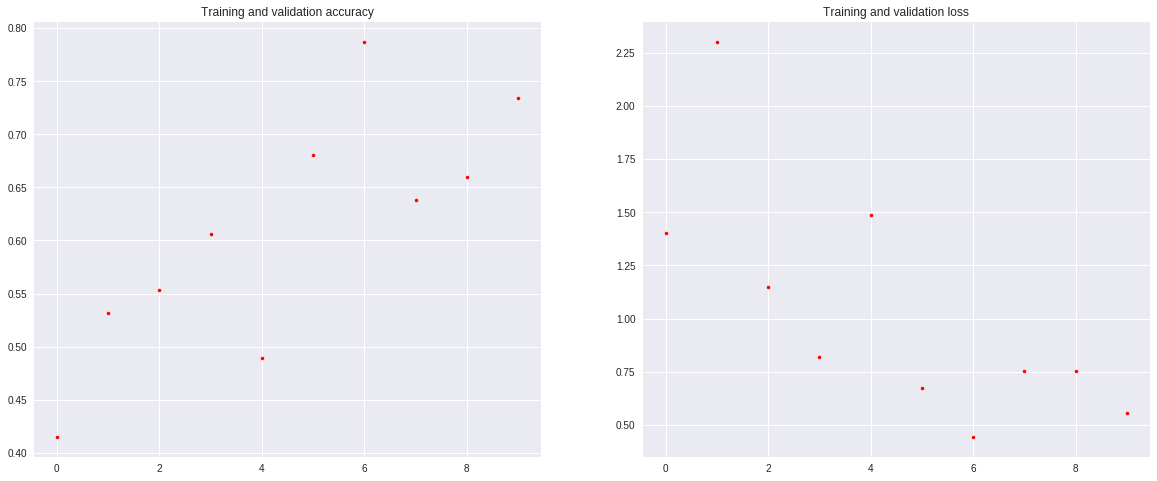

<Figure size 432x288 with 0 Axes>

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt


# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['acc']
    loss = history.history['loss']
    epochs = range(len(acc))

    
    plt.figure(figsize=(20, 8))
#     plt.figure(figsize=20.)
    plt.grid(False)
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r.')
    plt.title('Training and validation accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r.')
    plt.title('Training and validation loss')
    
    plt.show()
    plt.savefig('acc_vs_epochs.png')
    
plot_training(history)

###Running the Model

Let's now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

In [0]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = finetune_model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a Zohar")
  else:
    print(fn + " is a Alma")
 

### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

In [0]:
%matplotlib inline
# !pip install -U --force-reinstall matplotlib

import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
from tensorflow.keras import layers,models


# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in finetune_model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = finetune_model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
Alma_img_files = [os.path.join(train_Alma_dir, f) for f in train_Alma_names]
Zohar_img_files = [os.path.join(train_Zohar_dir, f) for f in train_Zohar_names]
img_path = random.choice(Alma_img_files + Zohar_img_files)

img = load_img('/content/drive/My Drive/Training/Alma/IMG_20140304_065535.jpg', target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in finetune_model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
#     print (n_features)
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')